In [2]:
#Libraries we need
import tensorflow as tf
#TFP bijector class and PDFs aff all sorts
import tensorflow_probability as tfp
import numpy as np
from tensorflow.keras.layers import Layer, Dense, ReLU
#Model to save the model otherwise I had problems
from tensorflow.keras import Model

#Shortnames
tfd = tfp.distributions
tfb = tfp.bijectors
K = tf.keras
#Change datatype here for extra precision
DTYPE=tf.float32

In [12]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:

##NN layer inside the RNVP (scale and shift)
class NN(Layer):
  
  def __init__(self,input_shape,output_shape,n_hidden = [512,512],activation = 'relu', name = 'NN'):
    super(NN,self).__init__(name = name)
    layers = []
    for layer, parameters in enumerate(n_hidden):
      layers.append(Dense(parameters, activation = activation, name='dense_1_{}'.format(layer), kernel_initializer='glorot_normal',bias_initializer='zeros'))
    self.layer_list = layers
    #I played with initializers you might want to change them to something like uniform of normal
    self.s_layer = Dense(output_shape, activation ='tanh', name = 's',kernel_initializer='zeros',bias_initializer='zeros')
    self.t_layer = Dense(output_shape, activation = 'linear',name='t',kernel_initializer='zeros',bias_initializer='zeros')
    
  def call(self,x):
    input = x
    for layer in self.layer_list:
      input = layer(input)
    s = self.s_layer(input)
    t = self.t_layer(input)
    return s, t


#tfp realisazion of RNVP bijection layer Just put them in tfb Chain 
class RealNVP(tfb.Bijector):
  
  def __init__(self, input_shape, split = 2, n_hidden = [1024, 1024], validate_args=False, name = 'RealNVP'):
    super(RealNVP, self).__init__(
            forward_min_event_ndims=1,
            inverse_min_event_ndims=1,
            validate_args=validate_args,
            name=name
    )
    NN_input_shape = split[0]
    NN_output_shape = split[1]
    Network = NN(NN_input_shape,NN_output_shape, n_hidden)
    flowing_x = tf.keras.Input(NN_input_shape)
    s, t = Network(flowing_x)
    self.flowing_st = Model(flowing_x,[s,t],name='s_and_t_parametrized')
    self.split = split
  def _g_linear(self,x):
    s,t = self.flowing_st(x)
    return tfb.Chain([tfb.Shift(t),tfb.Scale(log_scale=s)])
  
  def _forward(self,x):
    x_1d, x_dD = tf.split(x,self.split,axis=-1)
    y_1d = x_1d
    y_dD = self._g_linear(x_1d).forward(x_dD)
    return tf.concat([y_1d,y_dD], axis = -1)
  
  def _inverse(self,y):
    y_1d, y_dD = tf.split(y,self.split,axis=-1)
    x_1d = y_1d
    x_dD = self._g_linear(y_1d).inverse(y_dD)
    return tf.concat([x_1d,x_dD], axis = -1)

  def _forward_log_det_jacobian(self, x):
    x_1d, x_dD = tf.split(x, self.split, axis=-1)
    return self._g_linear(x_1d).forward_log_det_jacobian(x_dD, event_ndims=1)

  def _inverse_log_det_jacobian(self, y):
    y_1d, y_dD = tf.split(y, self.split, axis=-1)
    return self._g_linear(y_1d).inverse_log_det_jacobian(y_dD, event_ndims=1)


#tfp realisazion of FFT bijection layer Just put them in tfb Chain 
class RealFFT(tfb.Bijector):
  
  def __init__(self, input_shape, validate_args=False, name = 'RealFFT',is_constant_jacobian=True):
    super(RealFFT, self).__init__(
            forward_min_event_ndims=1,
            inverse_min_event_ndims=1,
            validate_args=validate_args,
            name=name
    )
    self.input_shape = input_shape
  
  def _forward(self,x):
    x1,x1D,xD=tf.split(tf.signal.rfft(x),[1,self.input_shape//2-1,1],axis=-1)
    x1=tf.math.real(x1)
    x1D_real=tf.math.real(x1D)
    x1D_imag=tf.math.imag(x1D)
    xD=tf.math.real(xD)
    x = tf.concat([x1,x1D_real,x1D_imag,xD],axis=-1)
    return x
  
  def _inverse(self,y):
    y1, y1D_real, y1D_imag, yD = tf.split(y,[1,self.input_shape//2-1,self.input_shape//2-1,1],axis=-1)
    
    y1D_real = tf.concat([y1,y1D_real,yD],axis=-1)

    y1D_imag = tf.concat([0*y1,y1D_imag,0*yD],axis=-1)

    y = tf.signal.irfft(tf.complex(y1D_real,y1D_imag))

    return y

  def _inverse_log_det_jacobian(self, y):
    return -self._forward_log_det_jacobian(self._inverse(y))

  def _forward_log_det_jacobian(self, x):
    # The full log jacobian determinant would be tf.zero_like(x).
    # However, we circumvent materializing that, since the jacobian
    # calculation is input independent, and we specify it for one input.
    return tf.constant(42, x.dtype)




In [14]:
#Permutation we use
#Here its just [1,2,3,4] to [1,3,2,4] this is done because latter we use second half as input for the s and t of the firts
input_size=144
perm = []
for i in np.arange(input_size//2,step=2):
  perm+=[i]+[input_size//2+i]

for i in np.arange(1,input_size//2,step=2):
  perm+=[i]+[input_size//2+i]
perm1 = perm
perm = []
for i in np.arange(input_size//2,input_size,step=1):
  perm+=[i]

for i in np.arange(input_size//2,step=1):
  perm+=[i]
perm2=perm
perm1[50]

mvn2 = tfd.MultivariateNormalDiag(loc=[0.]*input_size)

#number of bijection layers
num_realnvp = 16
bijector_chain = []
#sequence of RNVP and permutation layers
bijector_chain.append(tfp.bijectors.Invert(RealFFT(input_shape=input_size)))
bijector_chain.append(tfp.bijectors.Permute(perm1))
for i in range(num_realnvp):
    bijector_chain.append(tfp.bijectors.Permute(perm2))
    #network parameters
    bijector_chain.append(RealNVP(input_shape=input_size, split=[input_size//2,input_size//2],n_hidden=[256,256]))
bijector_chain.append(tfp.bijectors.Permute(perm1))
bijector_chain.append(RealFFT(input_shape=input_size))

flow2 = tfd.TransformedDistribution(
    distribution=mvn2,
    #we reverse the secuence because its actually applied first bijector in the list first otherwise its in a different direction
    bijector=tfb.Chain(list(reversed(bijector_chain)))
)
print('trainable_variables: ', len(flow2.bijector.trainable_variables))

trainable_variables:  128


In [15]:
from tensorflow.keras.utils import Progbar

In [16]:
#E=lambda*(x**2-f**2)**2 so f is the shift between minima 
#Start from one and increasy up to 5 
@tf.function
def Energy(y):
        lamd = 1.
        f = np.sqrt(1.2)
        a = 0.1
        m = 0.5
        kinetic_energy = tf.reduce_sum( m / ( 2 * a ) * (y-tf.roll(y,shift=-1,axis=1))**2,axis=-1)
        potential_energy = tf.reduce_sum(lamd * ( y**2 - f**2 )**2,axis=-1)
        return kinetic_energy + a*potential_energy


In [17]:
# Training loop
n_epochs = 10
n_iter = 1000
n_samples = 4096 
#KLD xs is configuration Energy is the energy of this configuration log_p0 KL_D is some constants to which to grad is applied
#More or less they normalize the value and make procedure somehow more stable
#put them to zero for standart KLD                                
@tf.function
def KL_Divergence(xs,energy,log_p0,KL_D):
    log_p1 = flow2.log_prob(xs)
    KL_D1 = (log_p1+energy-KL_D)*tf.exp(log_p1-log_p0)/tf.abs(KL_D)
    KL_D = KL_D1
    return tf.math.reduce_mean(KL_D)
  
#these are optimizer and params
lr_decay = .1
learning_rate = .0001
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
checkpoint_directory = './'
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=flow2)
for epoch in range(n_epochs):
    print('Epoch {:}/{:}'.format(epoch, n_epochs))
    checkpoint.save(checkpoint_directory+'ckpt_12_144_fft_{}'.format(epoch))  
    progbar = Progbar(n_iter)
    for iter in range(n_iter):
        accum_gradient = [tf.zeros_like(this_var) for this_var in flow2.trainable_variables]
        for k in range(1):
          xs_m = flow2.sample(n_samples)
          es_m = Energy(xs_m)
          log_p0 = flow2.log_prob(xs_m)
          KL_D=tf.reduce_mean(es_m+log_p0)
          with tf.GradientTape() as ae_tape:
              loss = KL_Divergence(xs_m,es_m,log_p0,KL_D)
          
          gradients = ae_tape.gradient(loss, flow2.trainable_variables)
          accum_gradient = [(acum_grad+grad) for acum_grad, grad in zip(accum_gradient, gradients)]
        
        accum_gradient = [this_grad/10. for this_grad in accum_gradient]
        optimizer.apply_gradients(zip(accum_gradient, flow2.trainable_variables))
        progbar.add(1, values=[('loss', KL_D)])

C:\Users\Savch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 0/10
1000/1000 [==============================] - 725s 719ms/step - loss: 24.5851
Epoch 1/10
1000/1000 [==============================] - 702s 702ms/step - loss: 5.0140
Epoch 2/10
1000/1000 [==============================] - 700s 700ms/step - loss: 4.8205
Epoch 3/10
1000/1000 [==============================] - 700s 700ms/step - loss: 4.6799
Epoch 4/10
1000/1000 [==============================] - 701s 701ms/step - loss: 4.5636
Epoch 5/10
1000/1000 [==============================] - 700s 700ms/step - loss: 4.4670
Epoch 6/10
1000/1000 [==============================] - 700s 700ms/step - loss: 4.3810
Epoch 7/10
1000/1000 [==============================] - 700s 700ms/step - loss: 4.3017
Epoch 8/10
1000/1000 [==============================] - 702s 702ms/step - loss: 4.2104
Epoch 9/10
1000/1000 [==============================] - 700s 700ms/step - loss: 4.1147


In [18]:
#E=lambda*(x**2-f**2)**2 so f is the shift between minima 
#Start from one and increasy up to 5 
@tf.function
def Energy(y):
        lamd = 1.
        f = np.sqrt(1.3)
        a = 0.1
        m = 0.5
        kinetic_energy = tf.reduce_sum( m / ( 2 * a ) * (y-tf.roll(y,shift=-1,axis=1))**2,axis=-1)
        potential_energy = tf.reduce_sum(lamd * ( y**2 - f**2 )**2,axis=-1)
        return kinetic_energy + a*potential_energy
    
    
# Training loop
n_epochs = 10
n_iter = 1000
n_samples = 4096 
#KLD xs is configuration Energy is the energy of this configuration log_p0 KL_D is some constants to which to grad is applied
#More or less they normalize the value and make procedure somehow more stable
#put them to zero for standart KLD                                
@tf.function
def KL_Divergence(xs,energy,log_p0,KL_D):
    log_p1 = flow2.log_prob(xs)
    KL_D1 = (log_p1+energy-KL_D)*tf.exp(log_p1-log_p0)/tf.abs(KL_D)
    KL_D = KL_D1
    return tf.math.reduce_mean(KL_D)
  
#these are optimizer and params
lr_decay = .1
learning_rate = .0001
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
checkpoint_directory = './'
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=flow2)
for epoch in range(n_epochs):
    print('Epoch {:}/{:}'.format(epoch, n_epochs))
    checkpoint.save(checkpoint_directory+'ckpt_13_144_fft_{}'.format(epoch))  
    progbar = Progbar(n_iter)
    for iter in range(n_iter):
        accum_gradient = [tf.zeros_like(this_var) for this_var in flow2.trainable_variables]
        for k in range(1):
          xs_m = flow2.sample(n_samples)
          es_m = Energy(xs_m)
          log_p0 = flow2.log_prob(xs_m)
          KL_D=tf.reduce_mean(es_m+log_p0)
          with tf.GradientTape() as ae_tape:
              loss = KL_Divergence(xs_m,es_m,log_p0,KL_D)
          
          gradients = ae_tape.gradient(loss, flow2.trainable_variables)
          accum_gradient = [(acum_grad+grad) for acum_grad, grad in zip(accum_gradient, gradients)]
        
        accum_gradient = [this_grad/10. for this_grad in accum_gradient]
        optimizer.apply_gradients(zip(accum_gradient, flow2.trainable_variables))
        progbar.add(1, values=[('loss', KL_D)])

Epoch 0/10
1000/1000 [==============================] - 706s 700ms/step - loss: 5.7944
Epoch 1/10
1000/1000 [==============================] - 702s 702ms/step - loss: 5.6380
Epoch 2/10
1000/1000 [==============================] - 703s 703ms/step - loss: 5.4820
Epoch 3/10
1000/1000 [==============================] - 703s 703ms/step - loss: 5.3335
Epoch 4/10
1000/1000 [==============================] - 702s 702ms/step - loss: 5.2024
Epoch 5/10
1000/1000 [==============================] - 701s 701ms/step - loss: 5.0952
Epoch 6/10
1000/1000 [==============================] - 701s 701ms/step - loss: 5.0107
Epoch 7/10
1000/1000 [==============================] - 709s 709ms/step - loss: 4.9394
Epoch 8/10
1000/1000 [==============================] - 700s 700ms/step - loss: 4.8844
Epoch 9/10
1000/1000 [==============================] - 702s 702ms/step - loss: 4.8331


In [19]:
#E=lambda*(x**2-f**2)**2 so f is the shift between minima 
#Start from one and increasy up to 5 
@tf.function
def Energy(y):
        lamd = 1.
        f = np.sqrt(1.4)
        a = 0.1
        m = 0.5
        kinetic_energy = tf.reduce_sum( m / ( 2 * a ) * (y-tf.roll(y,shift=-1,axis=1))**2,axis=-1)
        potential_energy = tf.reduce_sum(lamd * ( y**2 - f**2 )**2,axis=-1)
        return kinetic_energy + a*potential_energy
    
    
# Training loop
n_epochs = 10
n_iter = 1000
n_samples = 4096 
#KLD xs is configuration Energy is the energy of this configuration log_p0 KL_D is some constants to which to grad is applied
#More or less they normalize the value and make procedure somehow more stable
#put them to zero for standart KLD                                
@tf.function
def KL_Divergence(xs,energy,log_p0,KL_D):
    log_p1 = flow2.log_prob(xs)
    KL_D1 = (log_p1+energy-KL_D)*tf.exp(log_p1-log_p0)/tf.abs(KL_D)
    KL_D = KL_D1
    return tf.math.reduce_mean(KL_D)
  
#these are optimizer and params
lr_decay = .1
learning_rate = .0001
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
checkpoint_directory = './'
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=flow2)
for epoch in range(n_epochs):
    print('Epoch {:}/{:}'.format(epoch, n_epochs))
    checkpoint.save(checkpoint_directory+'ckpt_14_144_fft_{}'.format(epoch))  
    progbar = Progbar(n_iter)
    for iter in range(n_iter):
        accum_gradient = [tf.zeros_like(this_var) for this_var in flow2.trainable_variables]
        for k in range(1):
          xs_m = flow2.sample(n_samples)
          es_m = Energy(xs_m)
          log_p0 = flow2.log_prob(xs_m)
          KL_D=tf.reduce_mean(es_m+log_p0)
          with tf.GradientTape() as ae_tape:
              loss = KL_Divergence(xs_m,es_m,log_p0,KL_D)
          
          gradients = ae_tape.gradient(loss, flow2.trainable_variables)
          accum_gradient = [(acum_grad+grad) for acum_grad, grad in zip(accum_gradient, gradients)]
        
        accum_gradient = [this_grad/10. for this_grad in accum_gradient]
        optimizer.apply_gradients(zip(accum_gradient, flow2.trainable_variables))
        progbar.add(1, values=[('loss', KL_D)])

Epoch 0/10
1000/1000 [==============================] - 706s 701ms/step - loss: 6.5706
Epoch 1/10
1000/1000 [==============================] - 706s 706ms/step - loss: 6.5246
Epoch 2/10
1000/1000 [==============================] - 701s 701ms/step - loss: 6.4820
Epoch 3/10
1000/1000 [==============================] - 700s 700ms/step - loss: 6.4487
Epoch 4/10
1000/1000 [==============================] - 701s 701ms/step - loss: 6.4183
Epoch 5/10
1000/1000 [==============================] - 700s 700ms/step - loss: 6.3907
Epoch 6/10
1000/1000 [==============================] - 700s 700ms/step - loss: 6.3646
Epoch 7/10
1000/1000 [==============================] - 700s 700ms/step - loss: 6.3425
Epoch 8/10
1000/1000 [==============================] - 703s 703ms/step - loss: 6.3210
Epoch 9/10
1000/1000 [==============================] - 700s 700ms/step - loss: 6.3014


In [20]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [21]:
#E=lambda*(x**2-f**2)**2 so f is the shift between minima 
#Start from one and increasy up to 5 
@tf.function
def Energy(y):
        lamd = 1.
        f = np.sqrt(1.5)
        a = 0.1
        m = 0.5
        kinetic_energy = tf.reduce_sum( m / ( 2 * a ) * (y-tf.roll(y,shift=-1,axis=1))**2,axis=-1)
        potential_energy = tf.reduce_sum(lamd * ( y**2 - f**2 )**2,axis=-1)
        return kinetic_energy + a*potential_energy
    
    
# Training loop
n_epochs = 10
n_iter = 1000
n_samples = 4096 
#KLD xs is configuration Energy is the energy of this configuration log_p0 KL_D is some constants to which to grad is applied
#More or less they normalize the value and make procedure somehow more stable
#put them to zero for standart KLD                                
@tf.function
def KL_Divergence(xs,energy,log_p0,KL_D):
    log_p1 = flow2.log_prob(xs)
    KL_D1 = (log_p1+energy-KL_D)*tf.exp(log_p1-log_p0)/tf.abs(KL_D)
    KL_D = KL_D1
    return tf.math.reduce_mean(KL_D)
  
#these are optimizer and params
lr_decay = .1
learning_rate = .0001
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
checkpoint_directory = './'
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=flow2)
for epoch in range(n_epochs):
    print('Epoch {:}/{:}'.format(epoch, n_epochs))
    checkpoint.save(checkpoint_directory+'ckpt_15_144_fft_{}'.format(epoch))  
    progbar = Progbar(n_iter)
    for iter in range(n_iter):
        accum_gradient = [tf.zeros_like(this_var) for this_var in flow2.trainable_variables]
        for k in range(1):
          xs_m = flow2.sample(n_samples)
          es_m = Energy(xs_m)
          log_p0 = flow2.log_prob(xs_m)
          KL_D=tf.reduce_mean(es_m+log_p0)
          with tf.GradientTape() as ae_tape:
              loss = KL_Divergence(xs_m,es_m,log_p0,KL_D)
          
          gradients = ae_tape.gradient(loss, flow2.trainable_variables)
          accum_gradient = [(acum_grad+grad) for acum_grad, grad in zip(accum_gradient, gradients)]
        
        accum_gradient = [this_grad/10. for this_grad in accum_gradient]
        optimizer.apply_gradients(zip(accum_gradient, flow2.trainable_variables))
        progbar.add(1, values=[('loss', KL_D)])

Epoch 0/10
1000/1000 [==============================] - 706s 701ms/step - loss: 8.1382
Epoch 1/10
1000/1000 [==============================] - 705s 705ms/step - loss: 8.1154
Epoch 2/10
1000/1000 [==============================] - 701s 701ms/step - loss: 8.0926
Epoch 3/10
1000/1000 [==============================] - 700s 700ms/step - loss: 8.0750
Epoch 4/10
1000/1000 [==============================] - 700s 700ms/step - loss: 8.0577
Epoch 5/10
1000/1000 [==============================] - 700s 700ms/step - loss: 8.0419
Epoch 6/10
1000/1000 [==============================] - 702s 702ms/step - loss: 8.0260
Epoch 7/10
1000/1000 [==============================] - 700s 700ms/step - loss: 8.0136
Epoch 8/10
1000/1000 [==============================] - 700s 700ms/step - loss: 7.9990
Epoch 9/10
1000/1000 [==============================] - 700s 700ms/step - loss: 7.9863


In [22]:
#E=lambda*(x**2-f**2)**2 so f is the shift between minima 
#Start from one and increasy up to 5 
@tf.function
def Energy(y):
        lamd = 1.
        f = np.sqrt(1.6)
        a = 0.1
        m = 0.5
        kinetic_energy = tf.reduce_sum( m / ( 2 * a ) * (y-tf.roll(y,shift=-1,axis=1))**2,axis=-1)
        potential_energy = tf.reduce_sum(lamd * ( y**2 - f**2 )**2,axis=-1)
        return kinetic_energy + a*potential_energy
    
    
# Training loop
n_epochs = 50
n_iter = 1000
n_samples = 4096 
#KLD xs is configuration Energy is the energy of this configuration log_p0 KL_D is some constants to which to grad is applied
#More or less they normalize the value and make procedure somehow more stable
#put them to zero for standart KLD                                
@tf.function
def KL_Divergence(xs,energy,log_p0,KL_D):
    log_p1 = flow2.log_prob(xs)
    KL_D1 = (log_p1+energy-KL_D)*tf.exp(log_p1-log_p0)/tf.abs(KL_D)
    KL_D = KL_D1
    return tf.math.reduce_mean(KL_D)
  
#these are optimizer and params
lr_decay = .1
learning_rate = .0001
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
checkpoint_directory = './'
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=flow2)
for epoch in range(n_epochs):
    print('Epoch {:}/{:}'.format(epoch, n_epochs))
    checkpoint.save(checkpoint_directory+'ckpt_16_144_fft_{}'.format(epoch))  
    progbar = Progbar(n_iter)
    for iter in range(n_iter):
        accum_gradient = [tf.zeros_like(this_var) for this_var in flow2.trainable_variables]
        for k in range(1):
          xs_m = flow2.sample(n_samples)
          es_m = Energy(xs_m)
          log_p0 = flow2.log_prob(xs_m)
          KL_D=tf.reduce_mean(es_m+log_p0)
          with tf.GradientTape() as ae_tape:
              loss = KL_Divergence(xs_m,es_m,log_p0,KL_D)
          
          gradients = ae_tape.gradient(loss, flow2.trainable_variables)
          accum_gradient = [(acum_grad+grad) for acum_grad, grad in zip(accum_gradient, gradients)]
        
        accum_gradient = [this_grad/10. for this_grad in accum_gradient]
        optimizer.apply_gradients(zip(accum_gradient, flow2.trainable_variables))
        progbar.add(1, values=[('loss', KL_D)])

Epoch 0/50
1000/1000 [==============================] - 709s 703ms/step - loss: 9.8972
Epoch 1/50
 542/1000 [===============>..............] - ETA: 5:25 - loss: 9.8802

KeyboardInterrupt: 

In [ ]:
#E=lambda*(x**2-f**2)**2 so f is the shift between minima 
#Start from one and increasy up to 5 
@tf.function
def Energy(y):
        lamd = 1.
        f = np.sqrt(2)
        a = 0.1
        m = 0.5
        kinetic_energy = tf.reduce_sum( m / ( 2 * a ) * (y-tf.roll(y,shift=-1,axis=1))**2,axis=-1)
        potential_energy = tf.reduce_sum(lamd * ( y**2 - f**2 )**2,axis=-1)
        return kinetic_energy + a*potential_energy
    
    
# Training loop
n_epochs = 100
n_iter = 1000
n_samples = 4096 
#KLD xs is configuration Energy is the energy of this configuration log_p0 KL_D is some constants to which to grad is applied
#More or less they normalize the value and make procedure somehow more stable
#put them to zero for standart KLD                                
@tf.function
def KL_Divergence(xs,energy,log_p0,KL_D):
    log_p1 = flow2.log_prob(xs)
    KL_D1 = (log_p1+energy-KL_D)*tf.exp(log_p1-log_p0)/tf.abs(KL_D)
    KL_D = KL_D1
    return tf.math.reduce_mean(KL_D)
checkpoint_directory="C:\FFT\\"
#these are optimizer and params
lr_decay = .1
learning_rate = .0001
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=flow2)

#status = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_directory))

for epoch in range(n_epochs):
    print('Epoch {:}/{:}'.format(epoch, n_epochs))
    checkpoint.save(checkpoint_directory+'ckpt_30_144_fft_{}'.format(epoch))  
    progbar = Progbar(n_iter)
    for iter in range(n_iter):
        accum_gradient = [tf.zeros_like(this_var) for this_var in flow2.trainable_variables]
        for k in range(1):
          xs_m = flow2.sample(n_samples)
          es_m = Energy(xs_m)
          log_p0 = flow2.log_prob(xs_m)
          KL_D=tf.reduce_mean(es_m+log_p0)
          with tf.GradientTape() as ae_tape:
              loss = KL_Divergence(xs_m,es_m,log_p0,KL_D)
          
          gradients = ae_tape.gradient(loss, flow2.trainable_variables)
          accum_gradient = [(acum_grad+grad) for acum_grad, grad in zip(accum_gradient, gradients)]
        
        accum_gradient = [this_grad/10. for this_grad in accum_gradient]
        optimizer.apply_gradients(zip(accum_gradient, flow2.trainable_variables))
        progbar.add(1, values=[('loss', KL_D)])

Epoch 0/100
 557/1000 [===============>..............] - ETA: 5:21 - loss: 18.1240

In [ ]:
xs=flow2.sample(5*10**4).numpy()
import matplotlib.pyplot as plt
Xs=xs[:,60]

(array([3.47623543e-04, 5.21436395e-04, 1.39049417e-03, 4.34529429e-03,
        1.39049417e-02, 3.16338079e-02, 5.77055081e-02, 1.07068051e-01,
        1.80242994e-01, 2.92525514e-01, 4.35919923e-01, 5.53243442e-01,
        6.64482402e-01, 7.26533957e-01, 7.71724265e-01, 7.63903527e-01,
        7.38526599e-01, 6.50403986e-01, 5.65931421e-01, 4.76070689e-01,
        3.89686395e-01, 2.98087265e-01, 2.31691271e-01, 1.78157158e-01,
        1.37658994e-01, 1.14020589e-01, 7.75200952e-02, 5.70102979e-02,
        4.25839061e-02, 3.45885694e-02, 2.78098978e-02, 1.49478201e-02,
        1.21668303e-02, 1.14715829e-02, 7.64772587e-03, 4.17148251e-03,
        5.38817050e-03, 3.47623543e-03, 1.73811952e-03, 5.21435314e-04,
        1.39049561e-03, 6.95247806e-04, 6.95247086e-04, 3.47623543e-04,
        0.00000000e+00, 0.00000000e+00, 1.73811771e-04, 1.73811771e-04,
        1.73812132e-04, 1.73811771e-04]),
 array([-2.9333918 , -2.8183248 , -2.703258  , -2.588191  , -2.473124  ,
        -2.358057  , 

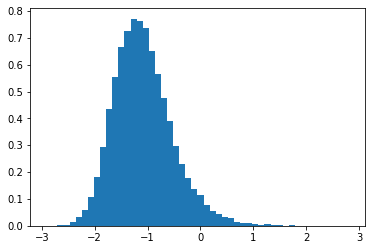

In [10]:
plt.hist(Xs,density=True,bins=50)

In [23]:
Xs.numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [24]:
def acceptance(energy_change):
    probability = np.exp(-energy_change)
    acceptance = np.random.uniform() < probability
    return acceptance

def swipe(start_x):
    x = start_x
    new_x = flow2.sample(1)
    d_log_p = flow2.log_prob(new_x)-flow2.log_prob(x)

    delta_e = Energy(new_x)-Energy(x)
    if acceptance(delta_e):
        x=new_x
    return x

In [53]:
step_num = 2000
xs = np.zeros((step_num,144),dtype=np.float32)
def training_loop(step_num):
    x = flow2.sample(1).numpy()
    for step in np.arange(0,step_num):
        x = swipe(x)
        xs[step] = x[0]
        if step%1000 == 0:
            print(step)

In [54]:
training_loop(step_num)
xs[:,0]

0


KeyboardInterrupt: 

In [55]:
np.unique(xs[:,0]).shape

(9,)

In [56]:
xs.shape

(2000, 144)